# Conversion Rate (CR) Prediction Service

The notebook contains EDA, data curation and modeling experimentation

**Objective**: to build model(s) for predicting users conversion rate probality per keyword depending on the device platfrom users employ for a search.

**DoD for the model performance**

MSE to be less then the ones can be obtained done with the following naïve/baseline models:

- predicting 0 for all entities - model-baseline (mb) 0
- predicting the mean of the entire train data set - mb1
- predicting the mean of the train data set by device - mb2
- predicting the mean of the train data set by entity_id - mb3

In [2]:
import os
import pandas as pd
import numpy as np
import pandas_profiling
import time
import sklearn
from sklearn.metrics import mean_squared_error as MSE
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


%matplotlib inline
plt.style.use('ggplot')

np.random.seed(2019)

In [3]:
DIR = os.getcwd()
PATH_DATA = os.path.join(os.path.dirname(DIR), 'bucket/data')
PATH_MODEL = os.path.join(os.path.dirname(DIR), 'bucket/model')

In [4]:
df = pd.read_csv(os.path.join(PATH_DATA, 'train/technical_test_training_data.csv'))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56181 entries, 0 to 56180
Columns: 165 entries, entity_id to Conversions
dtypes: int64(164), object(1)
memory usage: 70.7+ MB


Let's have a look at the data profile

In [5]:
df.profile_report()

Based on the data set profiling, the following conclusions/observation can be made:

- the target class is unbalanced with only about 17% of data points corresponding to a user conversion
- device type distribution is also skewed with the ratio of classes tablet:smartphone:computer ~ 1:1:2
- the data set has the time-series dimensiton and has two weeks worth of data
- number of features can be reduced by omiting some columns due to their correlation:
    - att2 ~ att6 ~ att28
    - att10 ~ att11 ~ att44
    - att17 ~ att19
    - att9 = att35
    - att4 = att26

The number of "att" features is ~160, they are binary however. 

I'm going to use a trick of dimensionality reduction by concatinating "attXX" features values into one long string "attrs". Resulting "attrs" feature is a binary number which can be converted to decimal and scaled between 0 and 1.

In [6]:
atts_cols = [i for i in df.columns if i.startswith('att')]
attrs = df[atts_cols]
attrs_int = attrs.apply(lambda x: int(''.join(x.astype(str)), 2), axis=1)

In [7]:
df['attrs'] = attrs_int

Now, we have only one feature which identifies a keyword. Let's however confirm that it's being fully identified by the "attrs" feature value.

In [10]:
# check how many entity_id with more then one set of "attXX"/"attrs" exist

sum(df.groupby('entity_id').agg(
    cnt_device = pd.NamedAgg('device', lambda x: x.nunique()),
    cnt_weeks = pd.NamedAgg('week', lambda x: x.nunique()),
    cnt_attrs = pd.NamedAgg('attrs', lambda x: x.nunique())
)['cnt_attrs'] > 1)

0

The data set contains the time-series dimension "week". It is however only two weeks of data present and as discussed with Julien, the seasonality prediction is beyond the scope of this problem. On that basis, the "week" columns is being dropped average convesion rate probability is being calculated across combinations of the fetures {entity_id, device, attrs} as 

$$\frac{\sum_{weeks} Conversions}{\sum_{weeks} Clicks}$$

In [8]:
# find CR using above assumption
df = df.groupby([*['entity_id', 'device', 'attrs'], 
                 *atts_cols], as_index=False)[['Clicks', 'Conversions']].sum()
df['cr'] = df.apply(lambda x: x['Conversions']/(x['Clicks'] + 1e-15), axis=1)

# filter out irrelevant data points with CR > 1
# the number of conversion exceeding number of clicks doesn't make much sense and may be a sign of broken tracking and data quality issue
df = df[df['cr'] <= 1]

# scale the combined attributes feature to be able to handle it
# otherwise numpy won't be able to allocated enough memory (C int size limitation)
# it's an idvised step anyways to avoid overfit to a particular feature due to its absolute value
df['attrs_scale'] = sklearn.preprocessing.minmax_scale(df['attrs'])

# drop columns not in use
df.drop(['Clicks', 'Conversions', 'attrs'], axis=1, inplace=True)

# encode the device column (a sklearn could be used for this either)
df = df.replace({"Computer": 0,
                 "Smartphone": 1,
                 "Tablet": 2})

In [9]:
df.head()

entity_id  device  att1  att2  att3  att4  att5  att6  att7  att8  ...  \
0          4       0     1     0     0     0     1     0     0     0  ...   
1          5       0     1     0     0     0     1     0     0     0  ...   
2          6       0     1     0     0     0     1     0     0     0  ...   
3          8       0     1     0     0     0     1     0     0     0  ...   
4          9       2     1     0     0     0     1     0     0     0  ...   

   att153  att154  att155  att156  att157  att158  att159  att160   cr  \
0       0       0       0       0       1       0       0       0  0.0   
1       0       0       0       0       1       0       0       0  0.0   
2       0       0       0       0       0       0       0       0  0.0   
3       0       0       0       0       0       0       0       0  0.0   
4       0       0       0       0       0       0       0       0  0.0   

   attrs_scale  
0     0.558212  
1     0.558212  
2     0.558212  
3     0.558212  
4     0.558212  

[5 rows x 164 columns]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37104 entries, 0 to 37246
Columns: 164 entries, entity_id to attrs_scale
dtypes: float64(2), int64(162)
memory usage: 46.7 MB


## Pearson correlation coeffitient

In [11]:
cols = [*['cr', 'device', 'attrs_scale'], *atts_cols]
corr = df[cols].corr()['cr']

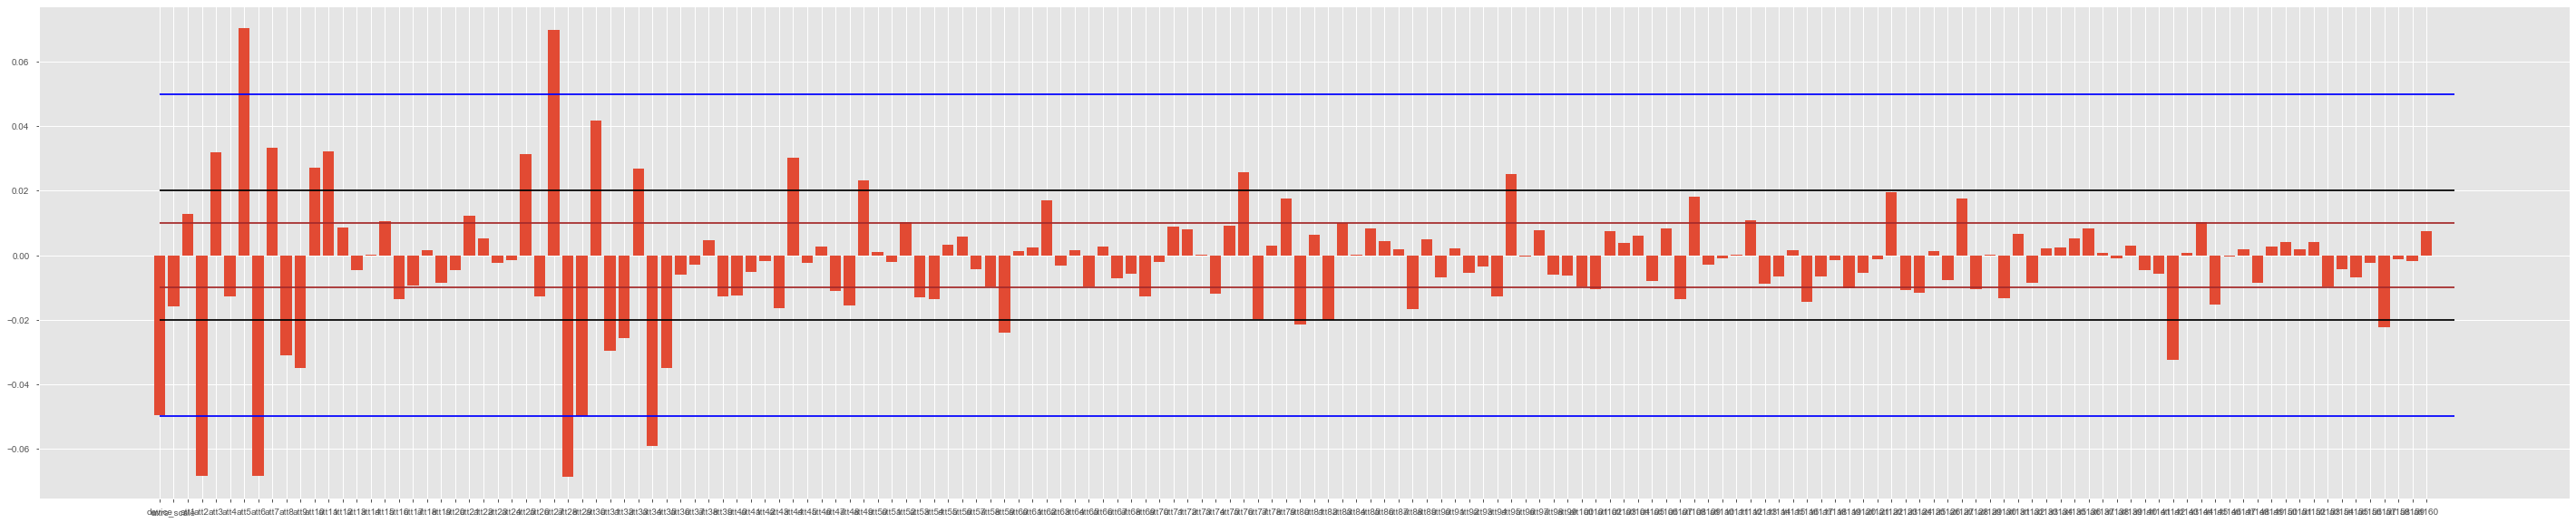

In [12]:
plt.figure(figsize=(50, 10))
plt.bar(x=[i for i in cols 
           if i != 'cr'],
        height=corr[1:])
plt.hlines(y=[-0.05, 0.05], 
           xmin=0, xmax=len(cols), 
           colors='b')
plt.hlines(y=[-0.02, 0.02], 
           xmin=0, xmax=len(cols), 
           colors='k')
plt.hlines(y=[-0.01, 0.01], 
           xmin=0, xmax=len(cols), 
           colors='brown')
plt.show()

## Baseline/naïve models performance

In [13]:
# baseline predictions
# baseline models performance

def baseline_mae(d: pd.DataFrame) -> dict:    
    d['cr_mb0'] = 0 
    d['cr_mb1'] = d['cr'].mean()
    d = d.merge(d.groupby(['device']).agg(
        cr_mb2 = pd.NamedAgg('cr', np.mean)
    ), on=['device'])
    d = d.merge(d.groupby(['entity_id']).agg(
        cr_mb3 = pd.NamedAgg('cr', np.mean)
    ), on=['entity_id'])
    
    metrics = {
        i: [MSE(d['cr'], d[i])] for i in [col for col in d.columns
                                            if col.startswith('cr_mb')]
    }
    
    return metrics

In [14]:
# check metrics across devices for prediction across 

MSE_baseline = baseline_mae(df.copy())

In [15]:
pd.DataFrame(MSE_baseline)

cr_mb0    cr_mb1    cr_mb2    cr_mb3
0  0.021005  0.019128  0.019025  0.007624

## Modeling

Let's build a liner model using the following features:
    
    - device
    - attrs_scale
    - attXX if abs value of the Pearson's corr coef >= alpha, abs(r) >= alpha

## Iter 1. Linear Regressors

In [16]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [19]:
alpha = 0.05 # -> v1 data set

In [25]:
cols_v1 = ['entity_id', 
           * ['device', 'attrs_scale'],
           * corr[abs(corr)>=alpha][1:].index, 
           'cr']
df_v1 = df[cols_v1]

Make a train/eval split using keyword ID. Unbalanced entity_id's data points distribution for different devices is not being taken to account yet.

In [26]:
train_ids = list(df['entity_id'].sample(frac=0.7, random_state=2019))
df_train_v1 = df_v1[df_v1['entity_id'].isin(train_ids)]
df_eval_v1 = df_v1[~df_v1['entity_id'].isin(train_ids)]

In [27]:
model_v1 = linear_model.LinearRegression(n_jobs=-1)

In [28]:
model_v1.fit(df_train_v1.drop(['entity_id', 'cr'], axis=1), df_train_v1['cr'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [30]:
def print_metrics(model, col_lose: []):
    print("train", MSE(df_train_v1['cr'], model.predict(df_train_v1.drop(col_lose, axis=1))))
    print("eval", MSE(df_eval_v1['cr'], model.predict(df_eval_v1.drop(col_lose, axis=1))))
    print("all", MSE(df_v1['cr'], model.predict(df_v1.drop(col_lose, axis=1))))

In [31]:
print_metrics(model_v1, ['entity_id', 'cr'])

train 0.018494414615266675
eval 0.021792233968567366
all 0.018861935210700995


In [33]:
# compare to baseline on eval data
pd.DataFrame(baseline_mae(df_eval_v1.copy()))

cr_mb0    cr_mb1    cr_mb2    cr_mb3
0  0.023251  0.021966  0.021844  0.004131

A very simplistic linear regression has a better performance (on the whole data set(!)) compared to all naïve baseline assumption except for mb3. This baseline model predicts CR per entity_id as to be equal to the averaged value across entity_id. It is not realistic to reach with a not completely overfitting model because in most of the cases there is only one data point per entity_id per week and device, hense 
$$\overline{CR_{i}} = CR_{i} => MSE_{i} = 0 $$

- Save and deploy the model. Implementation of a service to re-train the model to be done as weel (see README.md for details)
- Save train and eval data set to be consumed by re-train data service

In [34]:
import pickle

with open(os.path.join(PATH_MODEL, "v1/model.pkl"), 'wb') as f:
    pickle.dump(model_v1, f)

In [35]:
df_train_v1.to_csv(os.path.join(PATH_DATA, "train/v1/train.csv.gz"), index=False)
df_eval_v1.to_csv(os.path.join(PATH_DATA, "train/v1/eval.csv.gz"), index=False)

## Iter 2. Boosting Trees

Let's build a CART boosting model to improve overall performance and to define features importance

In [36]:
from xgboost import XGBRegressor
import xgboost as xgb

In [37]:
parameters = {
    "learning_rate": 0.1,
    "n_estimators": 40, 
    "max_depth": 10
}

dropped columns: entity_id, cr
MSE:
train 0.0183333251489748
eval 0.021820662896629466
all 0.018721966308595107


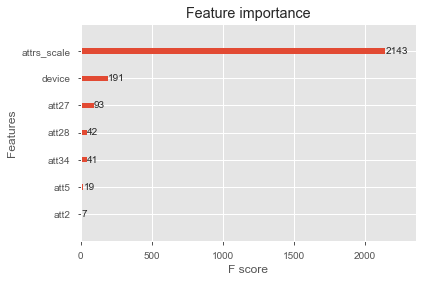

In [38]:
cols_lose = [['entity_id', 'cr'],
             ['entity_id', 'cr', 'device'],
             ['entity_id', 'cr', 'attrs_scale'],
             ['entity_id', 'cr', 'device', 'attrs_scale']]

for i in cols_lose[:1]:
    print(f"dropped columns: {', '.join(i)}")
    model_v2 = XGBRegressor(**parameters, 
                            verbosity=1, 
                            objective='reg:squarederror')

    model_v2.fit(df_train_v1.drop(i, axis=1), 
                 df_train_v1['cr'],
                 verbose=True)
    
    print("MSE:")
    print_metrics(model_v2, i)
    xgb.plot_importance(model_v2)

Despite the model to overfit to the "attrs_scale" it has the highest performance compares to the other four XGB models. It definetely makes sense since attrs_scale fully represents a given keyword/entity_id.

More data and further retraining can improve the MSE peformance. Another approach would be to split the task and first, predict the class CR > 0 -> 1, or CR = 0 -> 0.

In [39]:
with open(os.path.join(PATH_MODEL, "v1/model.pkl"), 'wb') as f:
    pickle.dump(model_v1, f)

## Iter 2*. Linear Regressors With Corrections

In [40]:
model_v3 = sklearn.linear_model.BayesianRidge(n_iter=10000, 
                                              tol=1e-6, lambda_1=1e-7,
                                              compute_score=True)

model_v3.fit(df_train_v1.drop(cols_lose[:1][0], axis=1), 
             df_train_v1['cr'])

print_metrics(model_v3, cols_lose[:1][0])

train 0.018494810893037034
eval 0.0217908988379582
all 0.018862138503328352


In [41]:
model_v4 = sklearn.linear_model.Lasso(max_iter=10000, tol=1e-6)
model_v4.fit(df_train_v1.drop(cols_lose[:1][0], axis=1), 
             df_train_v1['cr'])

print_metrics(model_v4, cols_lose[:1][0])

train 0.018764095431669868
eval 0.022036349296281614
all 0.019128766888390696


## (For fun) KNN estimator

Let's wether our models make sense

In [309]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV


params = {'n_neighbors':[300, 400, 500]}

for i in cols_lose[:1]:
    print(f"dropped columns: {', '.join(i)}")
    knn = neighbors.KNeighborsRegressor()
    
    knn_cv = GridSearchCV(knn, params, cv=2)
    knn_cv.fit(df_train_v0.drop(i, axis=1), 
                 df_train_v0['cr'])
    
    print("MSE:")
    print_metrics(knn_cv.best_estimator_, i)

dropped columns: entity_id, cr
MSE:
train 0.018349264009427622
eval 0.021667704806023404
all 0.01871908269997106


## Data classes balancing

The data set is unbalanced with cr = 0 being oversamples "class" of data points. Let's try to balance this out and (re-)train the model using the data sample with balanced data points distribution.

The data sampling/balancing is being according to the following steps:

* select data points with cr>0 as d_positive. size0=len(d_positive)
* randomly subset the data with cr==0 to the size=size0, d_negative
* randomly subset d_positive to the size of alpha*size0
* randomly subset d_negative to the size of alpha*size0
* union(d_positive, d_negative) -> df_balanced
* randomly shuffle df_balanced

*alpha* is a sampling hyper-parameter, it's being set to 0.7

The model is being re-train on balanced data set using several sampling iterations in a loop

In [503]:
from typing import Tuple


def data_balancing(df: pd.DataFrame, 
                   alpha=0.7,
                   random_state=(1, 2)): # -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Function to balance data set
    
    Args:
        df: input data frame
        alpha: balancing paramter
        random_state: tuple of random states to set seed
    
    Returns:
        Tuple of X_train, X_test, y_train, y_test
    """
    d_positive = df[df['cr'] > 0]
    size = int(alpha * len(d_positive))

    d_positive_sub = d_positive.sample(size, 
                                       replace=False, 
                                       random_state=random_state[0])    
    d_negative_sub = df[df['cr'] == 0].sample(size, 
                                              replace=False, 
                                              random_state=random_state[0])
    
    d_combined = pd.concat([d_positive_sub,
                            d_negative_sub],
                           axis=0)\
                   .sample(frac=1, 
                           random_state=random_state[1])\
                   .reset_index(drop=True)

    del d_positive_sub, d_positive, d_negative_sub, size

    X_train, X_test, y_train, y_test = train_test_split(d_combined.drop(['cr'], axis=1), 
                                                        d_combined['cr'], 
                                                        test_size=0.2, 
                                                        shuffle=True, 
                                                        random_state=2019)
    return X_train, X_test, y_train, y_test

In [504]:
model_vX.save_model('model_vX.xgb')
for i in range(20):
    X_train, X_test, y_train, y_test = data_balancing(df.drop(['entity_id'], axis=1),
                                                      random_state=(i + 1000, 
                                                                    i + 1100))
    model_vX.fit(X_train, y_train, xgb_model='model_vX.xgb',
                 verbose=False)

    print(f"Test MSE:{MSE(y_test, model_vX.predict(X_test))}")

    print(f"""Overall MSE: {MSE([*y_train, *y_test], 
              [*model_vX.predict(X_train), *model_vX.predict(X_test)])}""")
    model_vX.save_model('model_vX.xgb')

/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.043146173782710844
Overall MSE: 0.039288290041508425


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.036167658416353686
Overall MSE: 0.03956733069463931


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.0370321692241231
Overall MSE: 0.03908652994771216


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04268224785496322
Overall MSE: 0.03911851053155576


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04068786559458662
Overall MSE: 0.03919925401538084


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.040641813165853004
Overall MSE: 0.03896749793934621


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.036929363256433916
Overall MSE: 0.039728319221053035


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04416472492299008
Overall MSE: 0.041608834317317885


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.0390720743578426
Overall MSE: 0.04059072413789333


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.03862647238298842
Overall MSE: 0.04026409435219689


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.041728029932465244
Overall MSE: 0.04063816144642715


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04336262689968847
Overall MSE: 0.03999269745963401


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04154592981154866
Overall MSE: 0.03978756414817428


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04219881465721223
Overall MSE: 0.04055746201258919


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04184842724165538
Overall MSE: 0.03975223557420444


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.042959161841402665
Overall MSE: 0.03972494517502979


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.039327556021955076
Overall MSE: 0.039215906175284476


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.041615090270174834
Overall MSE: 0.03944411963536218


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test MSE:0.04681855668279185
Overall MSE: 0.039471069710819394


/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


KeyboardInterrupt: 

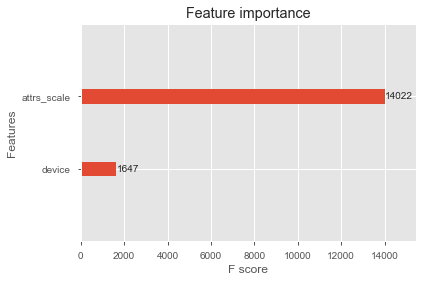

In [353]:
xgb.plot_importance(model_vX)

In [354]:
MSE(df['cr'], model_vX.predict(df.drop(['entity_id', 'cr'], axis=1)))

0.05749380793845296

## Some good practices when dealing with big number of dimensions

### Types casting+downcasting


This step is advised to use (especially when it comes to floating point data type) to remove unnessesarly precision to reduce the memory consumbtion and reduce computation complexety

In [12]:
from collections import namedtuple
from typing import NamedTuple


def type_downcast(vec: pd.Series) -> pd.Series:
    """Function to downcast data type of the feature
    
    Args:
        vec: pd.Series vector
       
    Returns:
        pd.Series
    """
    _types = namedtuple('types', ['int', 'float'])
    types = _types(int=[f"np.int{i}" for i in [8, 16, 32, 64]],
                   float=[f"np.float{i}" for i in [16, 32, 64, 128]])

    vec_dtype = vec.dtype
    if vec_dtype not in types._fields:
        return vec
    
    col_min = vec.min()
    col_max = vec.max()
    
    for tid, type_class in enumerate(types._fields):
        if vec_dtype != type_class:
            continue
    
        for _type in types[tid]:
            if type_class == 'int':
                type_min, type_max = np.iinfo(eval(_type)).min, np.iinfo(eval(_type)).max
            elif type_class == 'float':
                type_min, type_max = np.finfo(eval(_type)).min, np.finfo(eval(_type)).max
            else:
                break
            if type_min <= col_min and col_max <= type_max:
                    return vec.astype(eval(_type), copy=True)